In [1]:
# Searching a motif within the mic channel of a .kwd file
# the i-th motiff is in the file pattern_i.wav
# the raw data comes in file experiment.raw.kwd

# Definitions and functions

%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
import threading
from IPython.display import display
matplotlib.style.use('ggplot')


class chunkFunction():
    def __init__(self, chunk, function, *args, **kwargs):
        print args
        self.chunk = chunk
        self.func = function
        self.args = args
        self.kwargs = kwargs

    def start(self):
        logger.info('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.chunk.apply_filter(self.func, *self.args, **self.kwargs)
        logger.info('done')

class threadFunction():
    def __init__(self, function, *args, **kwargs):
        self.func = function
        self.args = args
        self.kwargs = kwargs
        self.out = None

    def run(self):
        logger.info('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.out = self.func(*self.args, **self.kwargs)
        logger.info("done")

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

import soundtools as st
import Kwik as oe

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

Computer: passaro


In [3]:
# User Parameters
bird_id = 'z020'
sess = 'day-2016-06-03' #day of recording
run = 1
processor = ''
pattern = 1

#channel in the .kwd file where the sound stream is
chan_name = "CH17"
chan_number = 16

#rms_threshold (how many standard deviations above mean value to consider supra-threshold event)
rms_thresh = 1.5

raw_file_folder = os.path.join(ss_data_folder, bird_id, sess)
raw_file_base_name = 'experiment'
raw_file_name = raw_file_base_name + processor + '.raw.kwd'
raw_file_path = os.path.join(raw_file_folder, raw_file_name)

# open the file in read mode
raw_file = h5py.File(raw_file_path, 'r')

# load it with the open-ephys api for version 2 of kiwk format
oe_file = oe.load(raw_file_path)

# print the list of recs in the file
raw_file['recordings'].keys()

[u'0', u'1', u'2', u'3']

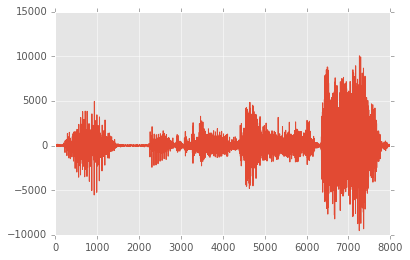

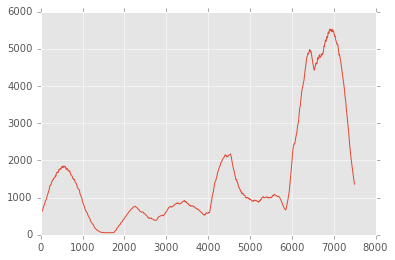

In [5]:
# prepare files for reading the stream/writing the timestamps
rec = 0 #recording group
pattern = 1


mot_file_name = raw_file_base_name + '.sng.kwe'
mot_file_path = os.path.join(raw_file_folder, mot_file_name)

log_file_name = 'search-motiff_{0:02}-rec_{1:03}.log'.format(pattern, rec)
log_file_path = os.path.join(raw_file_folder, log_file_name)

mic_file_name = raw_file_base_name + '-rec_{0:03}.mic.wav'.format(rec)
mic_file_path = os.path.join(raw_file_folder, mic_file_name)

# get the sound and the pattern
data_table = raw_file['/recordings'][str(rec)]['data']
chan_sf = oe.get_sample_rate(raw_file)

# Program parameters:
#filter
filt_lo = 7000 #Hz
filt_hi = 500 #Hz
# sonogram 
n_window = 256;
n_overlap = 192;
f_cut = 10000;
sigma = 1./1000.*chan_sf

#template match
window_env = 500

#make the filter for the data file
s_f = chan_sf
#The band where we expect most of the energy of zf song to be in
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

# read a bout from a wave file and prepare the templates 
pattern_name = 'motiff_' + str(pattern) + '.wav'
pattern_path = os.path.join(raw_file_folder, pattern_name)

pattern_sound = st.WavData2(pattern_path)
pattern_chunk = st.Chunk(pattern_sound)
pattern_chunk.apply_filter(st.bandpass_filter, s_f)
plt.plot((pattern_chunk.data))
pattern_envelope = st.envelope(pattern_chunk.data[:,0], window=window_env)
plt.figure()
plt.plot(pattern_envelope)
pattern_spectrogram = spectrogram(pattern_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap=n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

In [6]:
# create logger with 'spam_application'
logger = logging.getLogger('searching_motiff_nopandas')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

spectrogram_diff = st.spectrogram_diff
spectrogram_scores = st.spectrogram_scores
cluster_spectrograms = st.cluster_spectrograms
rms = st.rms

def find_happy_song(chan_sound, pattern_chunk, rms_thresh = 1.5):
    window_env = 500
    
    onset_resolution = 1
    rolling_method = 'pandas'
    logger.info('Begin to search')
    envelope_matches = st.match_by_envelope(chan_sound, pattern_chunk, 
                                             window_size=window_env, 
                                             rms_threshold=rms_thresh,
                                             window_step=onset_resolution, 
                                            rolling_method=rolling_method)
    
    offset = pattern_chunk.samples if rolling_method is 'pandas' else 0
    candidates = pd.DataFrame({'start' : (envelope_matches['peaks'] + 1) * onset_resolution - offset,
                           'env_corr': envelope_matches['corr'][envelope_matches['peaks']],
                           'spectral_diff': np.zeros_like(envelope_matches['peaks'], dtype=np.float)})
    
    n_candidates = len(candidates.index)
    logger.info('Found {0} candidates'.format(n_candidates))
    
    if n_candidates > 0:
        logger.info('Getting spectrogram scores')
        spectrogram_scores(pattern_chunk, chan_sound, candidates)
        if n_candidates > 2:
            logger.info('Clustering candidates')
            cluster_spectrograms(candidates)
    else:
        pass
    logger.debug('Returning clustered candidates')
    return candidates

# Read just the audio channel from the table
logger.info('Loading the data from rec {}'.format(rec))
audio_slice = h5.load_table_slice(data_table, np.arange(0, data_table.shape[0]), [chan_number])
chan_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[:,0], chan_sf, filt_hi, filt_lo),
                                     chan_sf, data_type=np.float)

logger.info('{} samples loaded'.format(chan_sound.n_samples))
#start a thread to find the song
task_find_happy_song = threadFunction(find_happy_song, chan_sound, pattern_chunk,
                                     rms_thresh = rms_thresh)

threads = []
t = threading.Thread(name= 'task_find_happy_song', 
                     target=task_find_happy_song.run)
threads.append(t)
t.start()

2016-07-08 17:46:54,297 - searching_motiff_nopandas - INFO - Loading the data from rec 0
2016-07-08 17:49:44,765 - searching_motiff_nopandas - INFO - 417856200 samples loaded
2016-07-08 17:49:44,767 - searching_motiff_nopandas - INFO - Starting function find_happy_song
2016-07-08 17:49:44,768 - searching_motiff_nopandas - INFO - Begin to search


<soundtools.DatSoundCompat instance at 0x7fb1701dea70>
<soundtools.Chunk instance at 0x7fb170184e18>
rms_thresh
1.5


In [7]:
t.isAlive()

False

In [8]:
result = task_find_happy_song.out
all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()
all_candidates

,index,env_corr,spectral_diff,start,bout
0,81,0.859831,0.385845,52683218,True
1,80,0.859841,0.388347,52683222,True
2,0,0.975792,0.415909,42743483,True
3,1,0.960530,0.421952,42728381,True
4,44,0.894937,0.435549,52705829,True
5,6,0.919817,0.443612,18396414,True
6,46,0.890106,0.449650,4424771,True
7,10,0.910860,0.449941,53627354,True
8,45,0.890182,0.450012,4424781,True
9,24,0.904602,0.452863,9138925,True


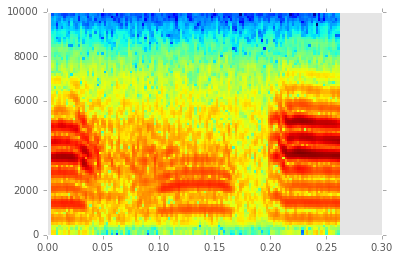

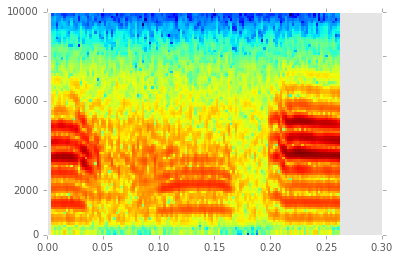

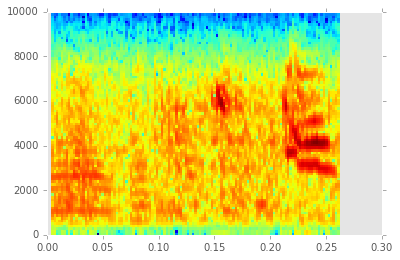

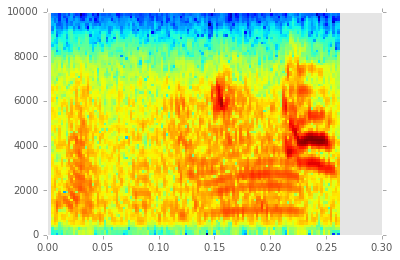

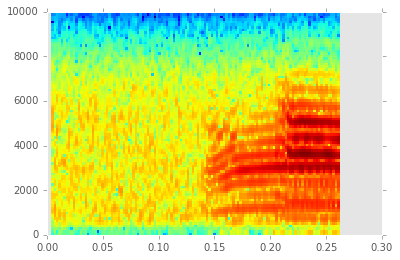

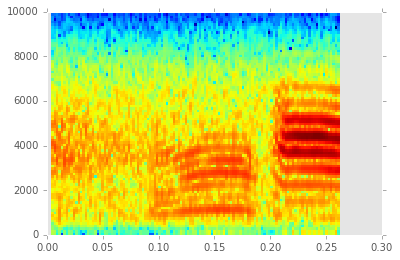

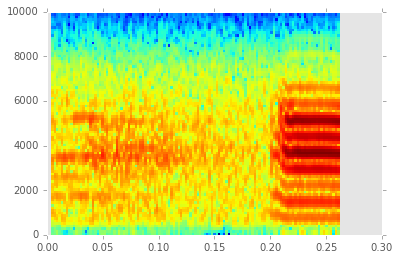

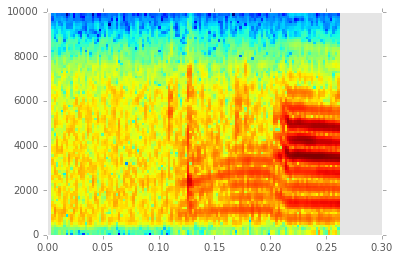

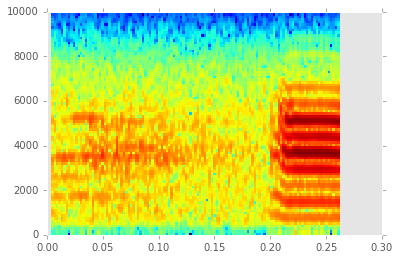

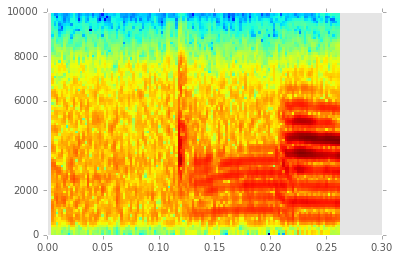

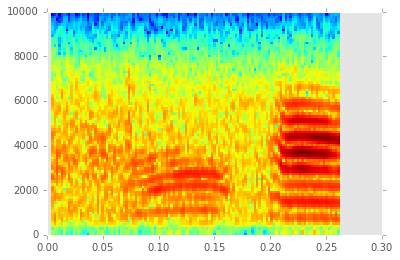

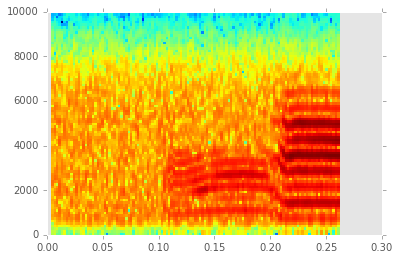

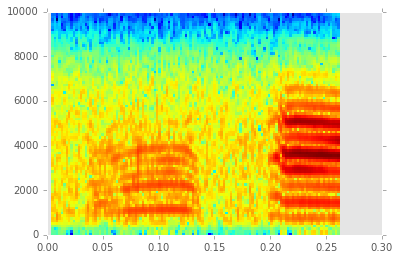

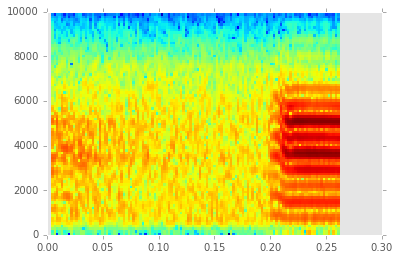

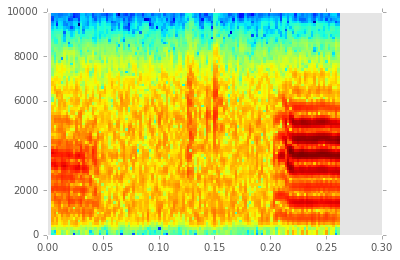

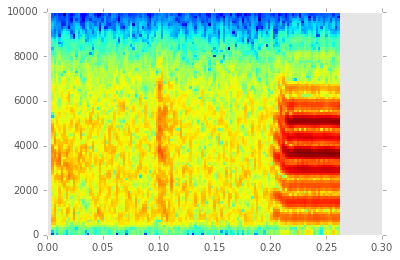

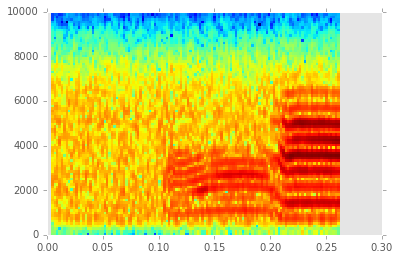

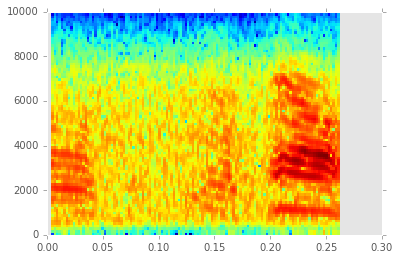

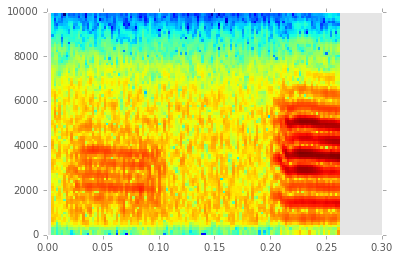

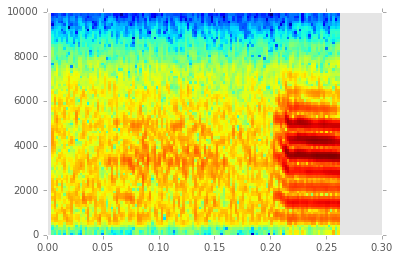

In [13]:
spectrogram_kwargs = {'nperseg': n_window,
                    'noverlap': n_overlap,
                    'window': sg.gaussian(n_window, sigma),
                    'scaling': 'spectrum'}

result = task_find_happy_song.out
all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()
rms_thresh = 1.638761;

for (i, start) in enumerate(all_candidates['start'][:20]):
    motif_start = start
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(series[0, :], s_f, **spectrogram_kwargs)
    # get the rms
    #print rms(st.bandpass_filter(series[:, 0], s_f))
    all_candidates.set_value(i, 'rms', st.rms(st.bandpass_filter(series[0,:], s_f)))
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

all_candidates = all_candidates[all_candidates['rms'] > rms_thresh].reset_index()

In [14]:
all_candidates

,level_0,index,env_corr,spectral_diff,start,bout,rms
0,0,81,0.859831,0.385845,52683218,True,44320.594348
1,1,80,0.859841,0.388347,52683222,True,44441.818606
2,2,0,0.975792,0.415909,42743483,True,19751.895221
3,3,1,0.960530,0.421952,42728381,True,21973.443974
4,4,44,0.894937,0.435549,52705829,True,44158.612694
5,5,6,0.919817,0.443612,18396414,True,27966.244780
6,6,46,0.890106,0.449650,4424771,True,41255.285931
7,7,10,0.910860,0.449941,53627354,True,29075.911012
8,8,45,0.890182,0.450012,4424781,True,41525.180682
9,9,24,0.904602,0.452863,9138925,True,22596.516419


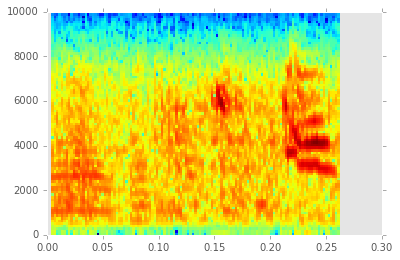

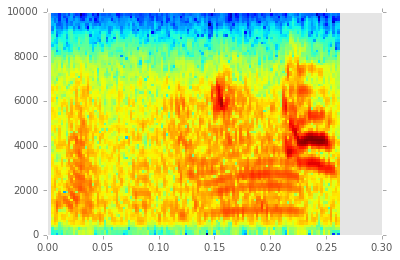

In [19]:
store_starts = np.concatenate([all_candidates['start'].values[2:4]])
store_starts

#confirm starting points
for start in store_starts:
    motif_start = start
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(series[0, :], s_f, **spectrogram_kwargs)
    # get the rms
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

In [24]:
# Save in the file
def append_rows(table, new_data):
    rows = table.shape[0]
    more_rows = new_data.shape[0]
    table.resize(rows + more_rows, axis=0)
    if table.size == (rows + more_rows):
        table[rows:] = new_data
    else:
        table[rows:,:] = new_data

def unlimited_rows_data(group, table_name, data):
    try:
        table = group.create_dataset(table_name, data=data, dtype=data.dtype, maxshape={None, None})
    except RuntimeError as e:
        if 'Name already exists' in str(e):
            table = group[table_name]
            append_rows(table, data)
        else:
            raise
    return table

def store_motiff(ev_file, rec, bout_starts, motiff_name):
    motiff_group = ev_file.require_group('/event_types/singing/{0}'.format(motiff_name))
    t_table = unlimited_rows_data(motiff_group, 'time_samples', bout_starts)
    r_table = unlimited_rows_data(motiff_group, 'recording', data=np.ones_like(bout_starts)*int(rec))
    
mot_file_name = raw_file_base_name + '.sng.kwe'
mot_file_path = os.path.join(raw_file_folder, mot_file_name)    

logger.info('Storing {0} motiff starts in {1}'.format(store_starts.size, mot_file_name))
mot_file = h5py.File(mot_file_path, 'a')
store_motiff(mot_file, rec, store_starts, 'motiff_1')
mot_file.close()

mic_file_name = raw_file_base_name + '-rec_{0:03}.mic.wav'.format(rec)
mic_file_path = os.path.join(raw_file_folder, mic_file_name)

logger.info('Saving mic channel in file {}'.format(mic_file_name))
wavfile.write(mic_file_path, chan_sf, np.array(chan_sound.stream[0,:], dtype='int16'))

2016-07-08 17:27:52,392 - searching_motiff_nopandas - INFO - Storing [42743483 42728381] motiff starts in experiment.sng.kwe


In [23]:
mic_file_name = raw_file_base_name + '-rec_{0:03}.mic.wav'.format(rec)
mic_file_path = os.path.join(raw_file_folder, mic_file_name)

logger.info('Saving mic channel in file {}'.format(mic_file_name))
wavfile.write(mic_file_path, chan_sf, np.array(chan_sound.stream[0,:], dtype='int16'))

2016-07-08 17:27:11,596 - searching_motiff_nopandas - INFO - Saving mic channel in file experiment-rec_005.mic.wav
